Copied from examples/demo.ipynb
Will use this notebook to test out several elements of lorenz attractor example.

Things to modify:
1. Likelihood for observing x from latent z is not Normal distribution. Rather, it is a Binomial distribution of some known (and is given as an input) number of observation. z is used as log odd since it is a logit of probability. Note a drawn random number has to be divided by n to get x (observed allele frequency).

2. Allow to input alpha = 2 N s, beta1 = 2 N mu1, beta-1 = 2 N mu-1 (back mutation) explicitly. 

3. Extend to a system of 3 SDEs for 2-locus diffusion. alpha1, alpha2, beta1, beta-1, beta2, beta-2, gamma (2 N r)


--> Got the 2-locus equation implemented! there is numerical instability issue because sometimes fi>=1, causing D_matrix to have negative diagonal element, and thus, Cholesky decomposition for getting the drift term does not work. 
--> Want to verify that SDE solver is accurate enough. To check this we should get SFS from the SDE curve (create a list of fequency that is randomly choose a time point and sample number - also binomial sample. Create a histogram of n). I expect 1-locus should be good, 2-locus may not be. 
--> With 1-locus working, I can move it forward to latent-sde example. 

In [146]:
import torch
from torch import nn
import numpy as np
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%matplotlib inline
import matplotlib.pyplot as plt

import torchsde
from typing import Sequence
def plot(ts, samples, xlabel, ylabel, title=''):
    ts = ts.cpu()
    samples = samples.squeeze().t().cpu()
    plt.figure()
    for i, sample in enumerate(samples):
        plt.plot(ts, sample, marker='x', label=f'sample {i}')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

Just like how each ordinary differential equation (ODE) is governed by a vector field, a stochastic differential equation (SDE) is governed by two vector fields, which are called the **drift** and **diffusion** functions:
$$dy(t) = \underbrace{f(t, y(t), \theta_f)}_{\text{drift}} dt + \underbrace{g(t, y(t), \theta_g)}_{\text{diffusion}} dW(t).$$
The output of $f$ is of the same size as the $d$-dimensional state, whereas the output of $g$ may be a matrix of size $(d, m)$. $W(t)$ is the Brownian motion (aka Wiener process), and it is $m$ dimensional. It is a stochastic process, and each random draw produces a function of time. 

Note that the second term on the right hand side $gdW$ is based on matrix-vector products.

### 1. Solving a simple SDE
To implement an SDE, we create a class with the functions `f` and `g`:

In [156]:
class SDE(nn.Module):

    def __init__(self):
        super().__init__()
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        self.alpha = 0. # alpha = 2 N s
        # assume beta1 = beta-1 --> contribution of forward and backward mutations cancel out each other.
    
    def f(self, t, y):
        return self.alpha * t + torch.zeros_like(y) # this is selection term (initially Ns = 0.1)
        # return torch.sin(t) + self.theta * y
    
    def g(self, t, y):
        return 2 * torch.cosh(0.5 * y)
        # return 0.3 * torch.sigmoid(torch.cos(t) * torch.exp(-y))

The functions `f` and `g` are arbitrarily chosen for demonstration purposes. The attributes noise_type and sde_type must be included to inform the solver about how to interpret the SDE, and determine which numerical methods are available. See [below](#noise_type) for more detail on how the output of g depends on the different noise types.

We use `diagonal` here, meaning the output of `g` should be a vector with the same shape as input `y`, and it is an element-wise function. 
Note that for any other noise type, we expect the output of `g` to be a matrix, and a batch matrix-vector product will be performed with the Brownian motion.

The codebase supports both Itô SDEs based on [Itô integrals](https://en.wikipedia.org/wiki/It%C3%B4_calculus) and Stratonovich SDEs based on [Stratonovich integrals](https://en.wikipedia.org/wiki/Stratonovich_integral).

Now we instantiate an object of the SDE class and call the function `sdeint` on it.

In [158]:
ys.shape

torch.Size([200, 10, 1])

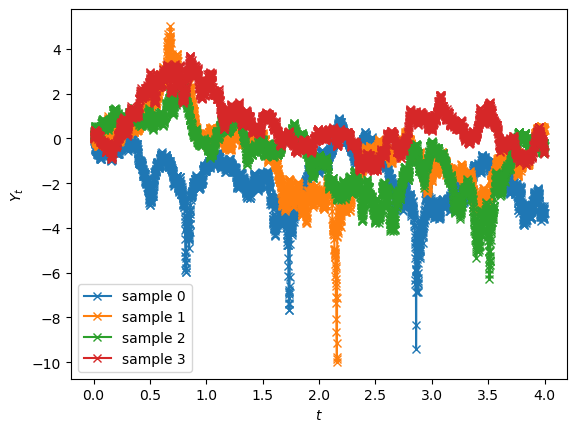

In [247]:
batch_size, state_size, t_size = 500, 1, 4000
sde = SDE()
ts = torch.linspace(0, 4, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=0.)

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size) = (100, 3, 1).

plot(ts, ys[:,:4:,:], xlabel='$t$', ylabel='$Y_t$')


Below check for each batch if ys[-1,n_batch,:] is nan. If so, go back in time until you find a real number. If it is positive, the allele got fixed and f final = 1. If it was negative, f final = 0. 
So I am saying that I should get fs from ys (logit^-1), find nan, fill them in by 0 or 1 depending on the latest number that is not nan.

In [248]:
fs = torch.zeros_like(ys)
for i in range(batch_size):
    if torch.isnan(ys[-1,i,:]):
        print(ys[-1,i,:])
        idx = -1
        while torch.isnan(ys[idx,i,:]):
            idx -= 1
        print(ys[idx,i,:])
        print(ys[idx,i,:].numpy()[0] > 0)
        fs[:idx-1,i,:] = torch.exp(ys[:idx-1,i,:])/(1+torch.exp(ys[:idx-1,i,:]))
        if ys[idx-1,i,:].numpy()[0] > 0:
            fs[idx-1:,i,:] = 1.
        else:
            fs[idx-1:,i,:] = 0.
    elif torch.isinf(ys[-1,i,:]):
        idx = -1
        while torch.isinf(ys[idx,i,:]):
            idx -= 1
        fs[:idx-1,i,:] = torch.exp(ys[:idx-1,i,:])/(1+torch.exp(ys[:idx-1,i,:]))
        fs[idx-1:,i,:] = 1.
    else:
        fs[:,i,:] = torch.exp(ys[:,i,:])/(1+torch.exp(ys[:,i,:]))
        # print(ys[idx-1,i,:])
        

tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([-inf])
False
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([inf])
True
tensor([nan])
tensor([i

In [251]:

# Get the final time allele frequency spectrum.
nsample = 10
xs = torch.distributions.Binomial(nsample, probs=fs[-1,:,:]).sample()


Todo: increase the batch size to get better resolution. Also use numpy.histogram to plot better. (i.e. in loglog scale to check if SFS ~ 1/f)

It looks like there is a bit of numerical instability issue (or precision issue?) which could mean that I should move to JAX and use float64. 

(array([ 71.,  42.,  49.,  42.,  37.,  34.,  43.,  32.,  42., 108.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

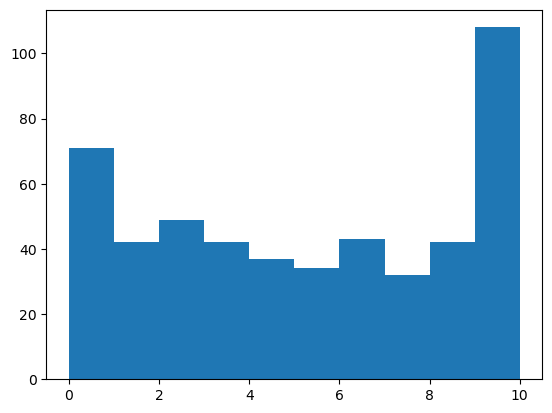

In [256]:
plt.hist(xs.numpy())


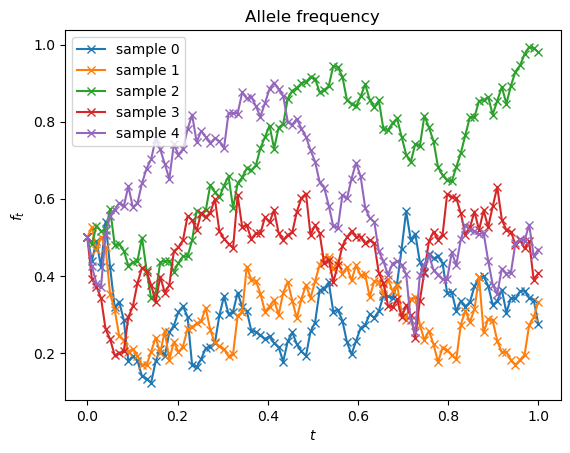

In [145]:
fs = torch.exp(ys) / (1 + torch.exp(ys))
plot(ts, fs, xlabel='$t$', ylabel='$f_t$', title='Allele frequency')

In [32]:
ys.shape

torch.Size([100, 5, 1])

For Itô SDEs `method='euler'` means the strong order 0.5 Euler-Maruyama method is used. Other possible methods include the strong order 1.0 `milstein` and the strong order 1.5 `srk`, both of which are of slightly higher order. If `method` is set to `None`, an appropriate solver would be chosen based on `noise_type` and `sde_type` under the hood.

To solve a Stratonovich SDE with drift and diffusion defined above, we need only change `sde_type` to `stratonovich` and supply an appropriate method of choice (e.g. the `midpoint` method):

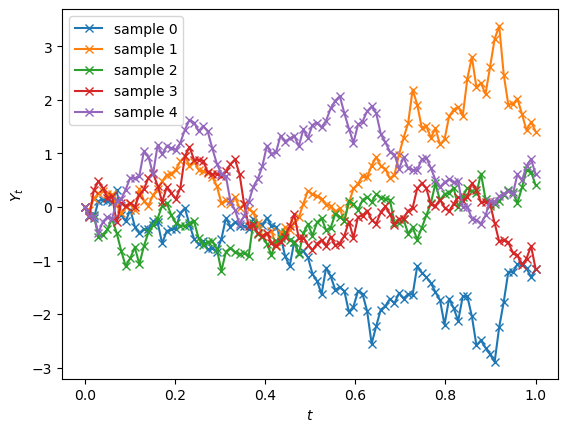

In [29]:
sde.sde_type = "stratonovich"

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method="midpoint")  # (t_size, batch_size, state_size) = (100, 3, 1).

plot(ts, ys, xlabel='$t$', ylabel='$Y_t$')

For Stratonovich SDEs, the methods `midpoint`, `euler_heun`, `heun`, `milstein`, and `log_ode` are supported. 

The drift and diffusion functions don't necessarily have to be called `f` and `g`. They can be methods with any name, so long as we provide these names to the solver when they differ from the default. The following is an example where `h` is used as the drift.

In [69]:
batch_size = 5
state_size=4
fs = torch.full(size=(batch_size, state_size), fill_value=0.01)
fAB,fAb,faB,fab = torch.split(fs, split_size_or_sections=(1, 1, 1,1), dim=1)


In [70]:
fAB.shape

torch.Size([5, 1])

In [47]:
torch.cat([fAB*(1-fAB), -fAB*fAb, -fAB*faB],dim=1).shape

torch.Size([5, 3])

In [72]:
fab.shape

torch.Size([5, 1])

In [73]:
D = torch.cat([torch.cat([fAB*(1-fAB), -fAB*fAb, -fAB*faB, -fAB*fab],dim=1),
torch.cat([-fAb*fAB, fAb*(1-fAb), -fAb*faB, -fAb*fab],dim=1),
torch.cat([-faB*fAB, -faB*fAb, faB*(1-faB), -faB*fab],dim=1), 
torch.cat([-fab*fAB, -fab*fAb, -fab*faB, fab*(1-fab)],dim=1)],dim=1)
print(D.shape)

torch.Size([5, 16])


In [74]:
D2=D.reshape(5,4,4)

In [50]:
D.shape

torch.Size([5, 9])

In [75]:
D2[0,:,:]

tensor([[ 9.9000e-03, -1.0000e-04, -1.0000e-04, -1.0000e-04],
        [-1.0000e-04,  9.9000e-03, -1.0000e-04, -1.0000e-04],
        [-1.0000e-04, -1.0000e-04,  9.9000e-03, -1.0000e-04],
        [-1.0000e-04, -1.0000e-04, -1.0000e-04,  9.9000e-03]])

In [76]:
sigma = torch.linalg.cholesky(D2)

In [58]:
sigma.shape


torch.Size([5, 3, 3])

In [63]:
torch.diag_embed(fs).shape

torch.Size([5, 3, 3])

In [64]:
print((1/(1-torch.diag_embed(fs))/torch.diag_embed(fs)* sigma).shape)

torch.Size([5, 3, 3])


In [56]:
print(torch.cat([fAB, fAb, faB], dim=1).shape)

torch.Size([5, 3])


tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500]]) tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500]]) tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500]])
tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500]]) tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500]]) tensor([[0.2500],
        [0.2500],
        [0.2500],
        [0.2500],
        [0.2500]])
tensor([[0.2841],
        [0.2646],
        [0.2655],
        [0.2450],
        [0.2673]]) tensor([[0.2362],
        [0.2792],
        [0.2655],
        [0.2442],
        [0.2694]]) tensor([[0.2471],
        [0.2537],
        [0.2624],
        [0.2489],
        [0.2461]])
tensor([[0.2936],
        [0.2638],
        [0.2845],
        [0.2330],
        [0.2754]]) tensor([[0.2511],
        [0.2805],
        [0.2602],
        [0.2411],
        [0.2516]])

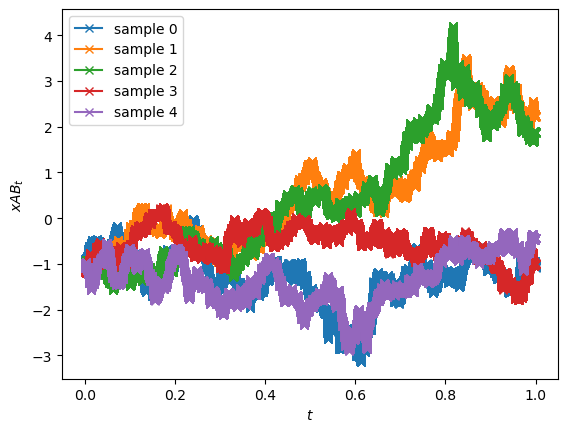

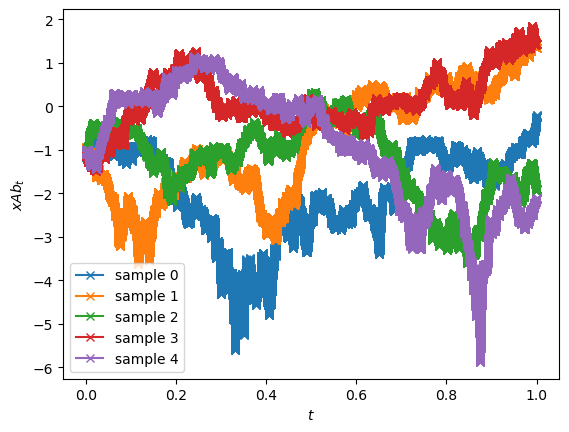

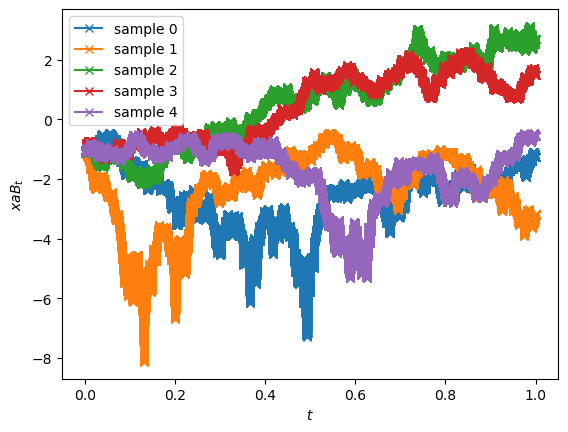

In [139]:
class SDE2locus(nn.Module):
    # use equation 3 and equation 8 from Ben Good's Genetics paper (2022)

    def __init__(self):
        super().__init__()
        self.theta = nn.Parameter(torch.tensor(0.1), requires_grad=False)  # Scalar parameter.
        self.noise_type = "general"
        self.sde_type = "ito"
        self.alpha1 = -0.02
        self.alpha2 = 0.
        self.beta1 = 0.01 # assume one way mutation from a to A
        self.gamma = 0.02
        
    
    def h(self, t, y):
        xAB, xAb, xaB = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        fAB = torch.exp(xAB) / (1 + torch.exp(xAB))
        fAb = torch.exp(xAb) / (1 + torch.exp(xAb))
        faB = torch.exp(xaB) / (1 + torch.exp(xaB))
        D = fAB * (1 - fAB - fAb - faB) - fAb * faB
        hAB = self.alpha1 + self.alpha2 + (self.beta1 * faB - self.gamma * D) * (1 + torch.exp(xAB)) ** 2 / torch.exp(xAB)
        hAb = self.alpha1 + (self.beta1 * fab + self.gamma * D) * (1 + torch.exp(xAb)) ** 2 / torch.exp(xAb)
        haB = self.alpha2 + (-self.beta1 * faB + self.gamma * D) * (1 + torch.exp(xaB)) ** 2 / torch.exp(xaB)
        print(fAB, fAb, faB)
        return torch.cat([hAB, hAb, haB], dim=1)
    
    def g(self, t, y):
        xAB, xAb, xaB = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        fAB = torch.exp(xAB) / (1 + torch.exp(xAB))
        fAb = torch.exp(xAb) / (1 + torch.exp(xAb))
        faB = torch.exp(xaB) / (1 + torch.exp(xaB))
        diagAB = fAB * 1 / (1 + torch.exp(xAB))
        diagAb = fAb * 1 / (1 + torch.exp(xAb))
        diagaB = faB * 1 / (1 + torch.exp(xaB))
        D_matrix = torch.cat([torch.cat([diagAB, -2*fAB*fAb, -2* fAB*faB],dim=1),
        torch.cat([torch.zeros_like(fAB), diagAb, -2 * fAb*faB],dim=1),
        torch.cat([torch.zeros_like(fAB), torch.zeros_like(fAB), diagaB],dim=1)],dim=1)
        D_matrix = D_matrix.reshape(fAB.shape[0],3,3)
        sigma = torch.linalg.cholesky(D_matrix)

        # gAB = 2 * torch.cosh(0.5 * xAB)
        # gAb = 2 * torch.cosh(0.5 * xAb)
        # gaB = 2 * torch.cosh(0.5 * xaB)
        gs = torch.diag_embed(torch.cat([1/fAB/(1-fAB),1/fAb/(1-fAb),1/faB/(1-faB)], dim=1))*sigma
        return gs
    
sde_new_name = SDE2locus()

batch_size, state_size, t_size = 5, 3, 70000
sde = SDE()
ts = torch.linspace(0, 1, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=torch.log(torch.tensor(0.25/0.75)))

with torch.no_grad():
    # Supply a dictionary to the argument `names`.
    ys = torchsde.sdeint(sde_new_name, y0, ts, method='euler', names={'drift': 'h'})
plot(ts, ys[:,:,0], xlabel='$t$', ylabel='$xAB_t$')
plot(ts, ys[:,:,1], xlabel='$t$', ylabel='$xAb_t$')
plot(ts, ys[:,:,2], xlabel='$t$', ylabel='$xaB_t$')


Instead of plotting what the latent SDE solves, we can also plot the timeseries of $f_A$, $f_B$ and $D$ which is a bit more interpretable.
But the upperbound and lowerbound seems incorrect... Need to double check the equations.

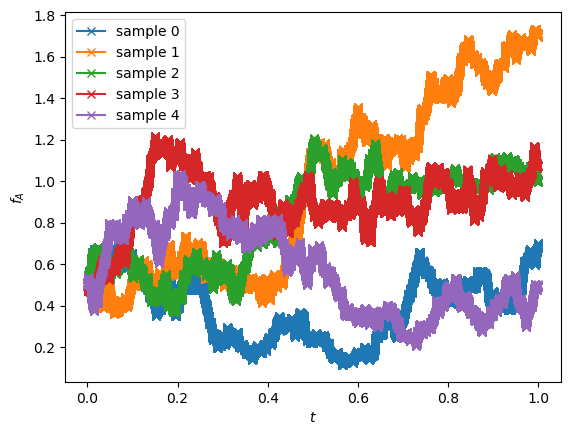

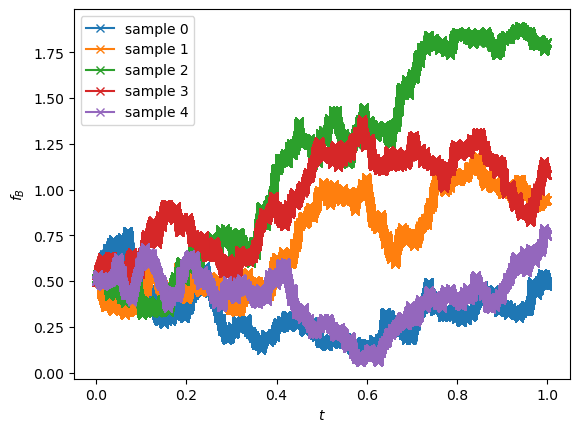

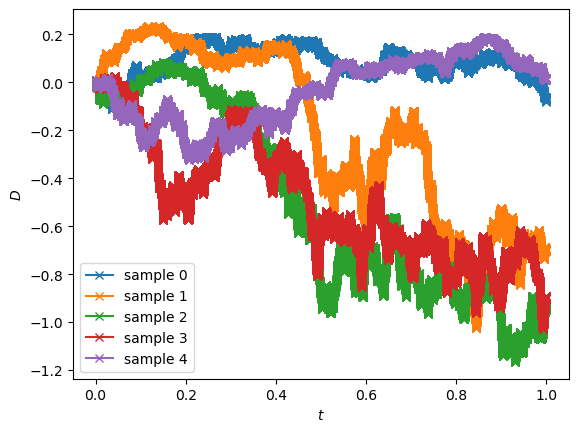

In [140]:
fs = torch.exp(ys) / (1 + torch.exp(ys))

fA = (fs[:,:,0] + fs[:,:,1])
fB = (fs[:,:,0] + fs[:,:,2])
D = (fs[:,:,0] * (1 - fs[:,:,0] - fs[:,:,1] - fs[:,:,2]) - fs[:,:,1] * fs[:,:,2])
plot(ts, fA, xlabel='$t$', ylabel='$f_A$')
plot(ts, fB, xlabel='$t$', ylabel='$f_B$')
plot(ts, D, xlabel='$t$', ylabel='$D$')


Trivially, the previous code may be adapted to run on GPUs, just by moving all tensors to a GPU:

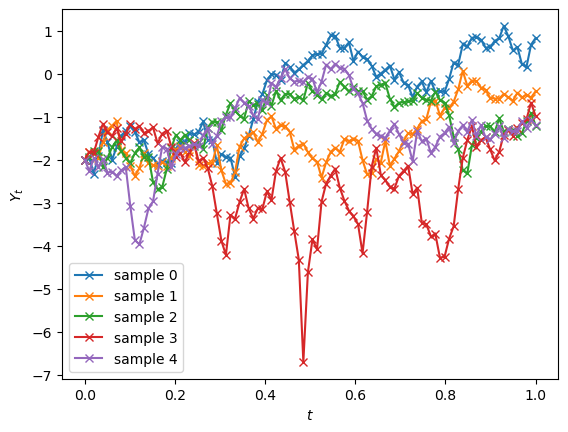

In [59]:
if torch.cuda.is_available():
    gpu = torch.device('cuda')
    sde = SDE().to(gpu)
    ts = ts.to(gpu)
    y0 = y0.to(gpu)
    with torch.no_grad():
        ys = torchsde.sdeint(sde, y0, ts, method='euler')  # (100, 3, 1).
    
    plot(ts, ys[:,:,0], xlabel='$t$', ylabel='$Y_t$')

A side note is that multi-GPU data parallel is possible with the existing codebase, but the use case has not been tested out extensively and may require defining non-standard SDE classes and methods. 

### 2. Explicit control over randomness from the Brownian motion
To gain control over the randomness, we draw Brownian motion samples by instantiating objects of classes `BrownianInterval`.

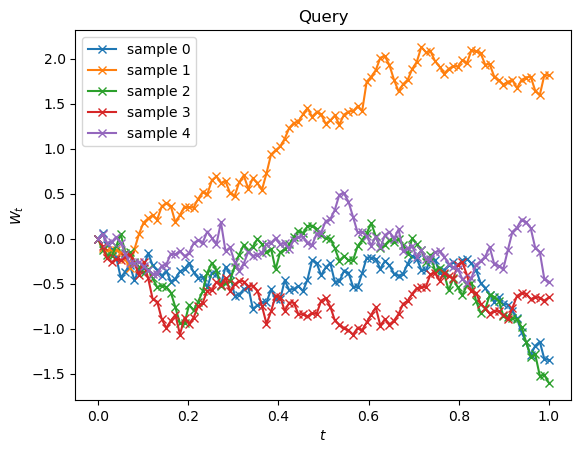

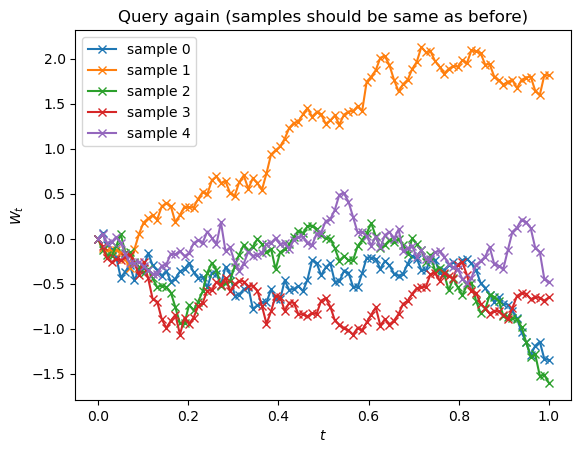

In [36]:
ts = torch.linspace(0, 1, t_size)
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))

bm_increments = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments, dim=0)))

plot(ts, bm_queries, xlabel='$t$', ylabel='$W_t$', title='Query')

bm_increments2 = torch.stack([bm(t0, t1) for t0, t1 in zip(ts[:-1], ts[1:])], dim=0)
bm_queries2 = torch.cat((torch.zeros(1, batch_size, state_size), torch.cumsum(bm_increments2, dim=0)))
plot(ts, bm_queries, xlabel='$t$', ylabel='$W_t$', 
     title='Query again (samples should be same as before)')

assert torch.allclose(bm_queries, bm_queries2)

We can also create the Brownian motion on GPUs by specifying `device`:

In [37]:
if torch.cuda.is_available():
    bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size), device=gpu)
    print(bm(0.0, 0.5))

tensor([[-0.2954],
        [ 1.2652],
        [-0.9145],
        [ 0.6317],
        [-0.0895]], device='cuda:0')


Having a Brownian motion object helps us gain control over the randomness better. We can feed the object into the solver such that the solver's solution is conditioned on this path. 

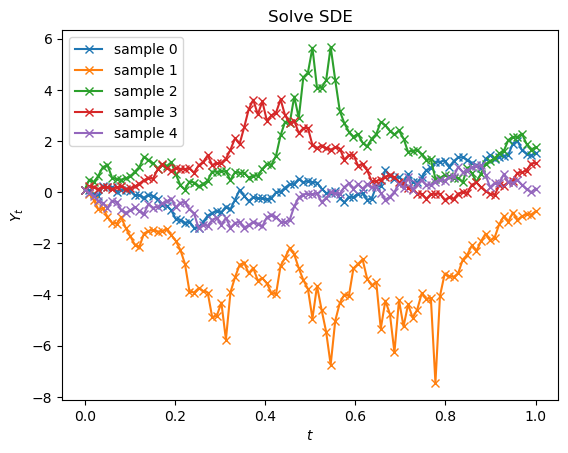

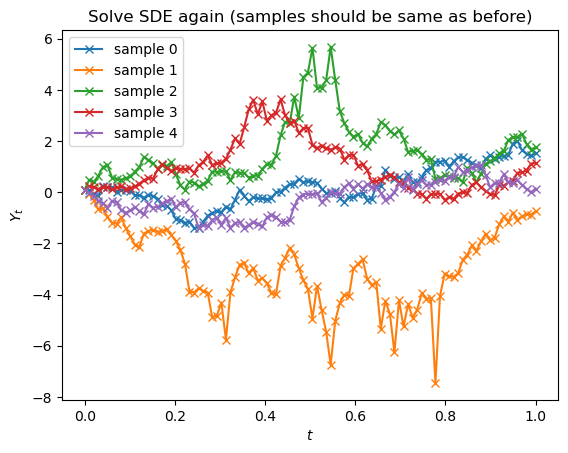

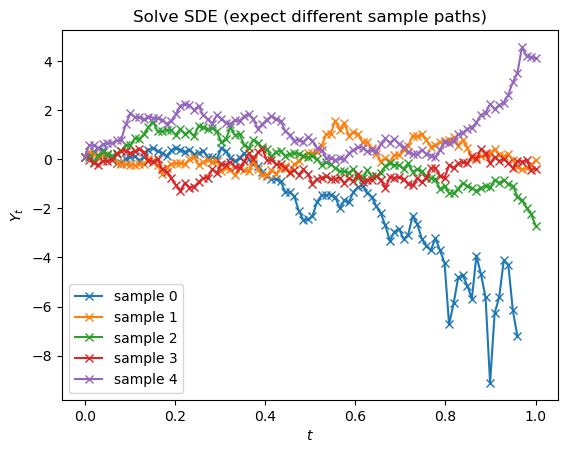

In [38]:
sde = SDE()
ts = torch.linspace(0, 1, t_size)
y0 = torch.zeros((batch_size, 1)).fill_(0.1)  # (batch_size, state_size).
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', title='Solve SDE')

with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE again (samples should be same as before)')

# Use a new BM sample, we expect different sample paths.
bm = torchsde.BrownianInterval(t0=0.0, t1=1.0, size=(batch_size, state_size))
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='milstein', bm=bm)
plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', 
     title='Solve SDE (expect different sample paths)')

### 3. Noise type of SDEs affects which solvers can be used and what strong orders can be attained<a id='noise_type'></a> 

The supported noise types of this codebase are "diagonal", "additive", "scalar", and "general".
The following is a simple summary of each type:
- "diagonal": The diffusion function is an elementwise function, whose output has the same size as that of the state (both are of size `(batch_size, state_size)`). There are `state_size` independent Brownian motions, each responsible for the noise of only a single state dimension.
- "additive": The diffusion function is constant w.r.t. the state (but not necessarily time). The output of the diffusion function is of size `(batch_size, state_size, brownian_size)`, and the system has `brownian_size` independent Brownian motions. The integral involving the Brownian motion can be loosely interpreted as integrating a sequence of matrix-vector products.
- "scalar": The diffusion function has output shape `(batch_size, state_size, 1)`, and a single Brownian motion is shared across all state dimensions. 
- "general": The diffusion function has output shape `(batch_size, state_size, brownian_size)`, and the system has `brownian_size` independent Brownian motions.

It is tempting to use the noise type configuration "general" for all problems. However, since there's little known structure for these SDEs, solvers with high strong-order cannot be constructed.

Lastly, for modeling problems, our limited experience have found "diagonal" to be a good setting, where flexibility of models and tractability of numerical integration is rather well-balanced. 

### 4. Computing gradients

Computing gradients through SDE solutions can be easily done by calling the `backward` function on loss tensors, or using `torch.autograd.grad`:

In [21]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(0.5850)


In [22]:
ys = torchsde.sdeint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
grad, = torch.autograd.grad(loss, sde.theta)
print(grad)

tensor(1.5949)


Switching to adjoint-mode gradient computation is as simple as replacing `sdeint` with `sdeint_adjoint`

In [23]:
ys = torchsde.sdeint_adjoint(sde, y0, ts, method='euler', bm=bm)
y_final = ys[-1]
target = torch.randn_like(y_final)
loss = ((target - y_final) ** 2).sum(dim=1).mean(dim=0)
loss.backward()
print(sde.theta.grad)

tensor(2.1279)
